In [1]:
from instapipeline import QuantiusAnnotation, SpotAnnotationAnalysis, clus, util

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from skimage import filters

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%matplotlib inline

In [19]:
worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

json_filename_list = ['Spot_density.json', 'Spots_density_no_tissue.json']
density_list = [0.008]
snr_mu_list = [10]

In [20]:
non_clumpy_color = '#fadadd'
clumpy_color = '#f88379'
anno_color_singles = 'xkcd:light blue'
anno_color_singles_plus = 'xkcd:mint green'
expert_1_color = 'xkcd:bright blue'
expert_2_color = '#ff69b4'

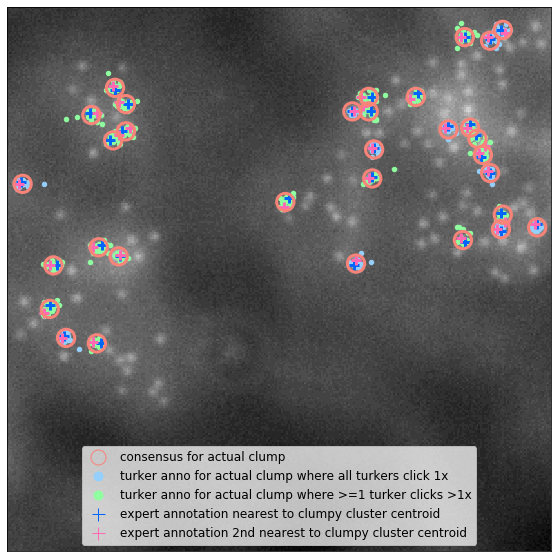

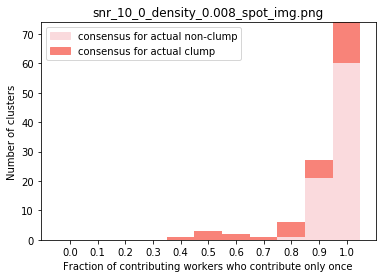

32 actual clumps
82 actual non-clumps


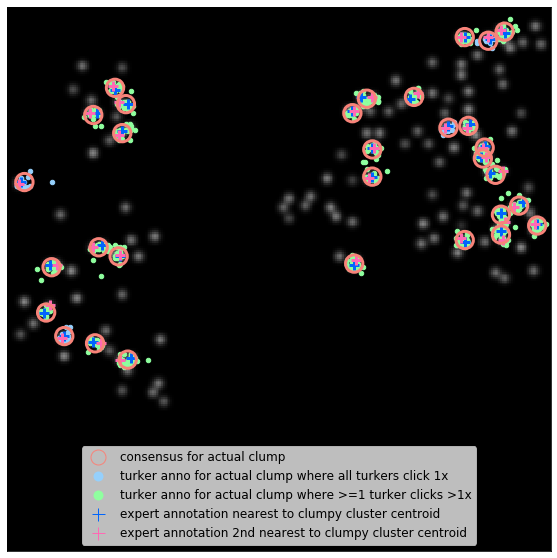

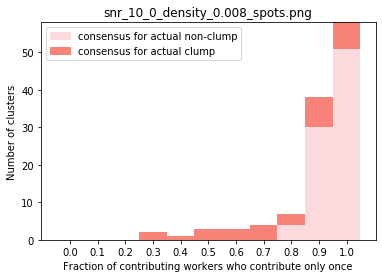

31 actual clumps
85 actual non-clumps


In [30]:
TPR_list_no_tissue = []
FPR_list_no_tissue = []
TPR_list_with_tissue = []
FPR_list_with_tissue = []
for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = './datasets/spot_arrays/'+img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = './datasets/spot_images/'+img_filename
            csv_filepath = './datasets/spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = './datasets/'+json_filename

            ba = QuantiusAnnotation(json_filepath, img_filename)
            sa = SpotAnnotationAnalysis(ba)
            
            anno_all = ba.df()
            ref_kdt = util.csv_to_kdt(csv_filepath, img_height)
            ref_array = np.asarray(ref_kdt.data)
            clusters = sa.get_clusters(anno_all, clustering_params)
            
            # Get large clusters
            cluster_size_threshold = clus.get_cluster_size_threshold(clusters)
            small_clusters, large_clusters = clus.sort_clusters_by_size(clusters, cluster_size_threshold)
            
            # For each cluster, calc and sort replication of each worker
            actual_clumps = []
            not_actual_clumps = []
            incorrect_clusters = []
            actual_clump_centroids = []
            not_actual_clump_centroids = []
            incorrect_centroids = []
            
            fig = plt.figure(figsize=(10,10))
            
            for i in range(len(large_clusters.index)):
                row = large_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                    workers.append(member[3])
                    
                # Calculate replication of unique workers for each cluster
                unique_workers = np.unique(workers)
                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))
                singles = num_instances_list.count(1)
                single_fraction = singles/len(unique_workers)
    
                # Are there at least two ref spots in the area of this cluster? (Is this cluster actually clumpy?)  
                centroid_coord = [row.iloc[0]['centroid_x'], row.iloc[0]['centroid_y']]
                dist, ind = ref_kdt.query([centroid_coord],k=2)
                index_0 = ind[0][0]
                index_1 = ind[0][1]
                neighbor_0 = ref_array[index_0]
                neighbor_1 = ref_array[index_1]
                if(dist[0][0] <= 4):
                    if ((neighbor_0[0] >= min(x_coords)) and (neighbor_0[0] <= max(x_coords)) and
                        (neighbor_0[1] >= min(y_coords)) and (neighbor_0[1] <= max(y_coords)) and 
                        (neighbor_1[0] >= min(x_coords)) and (neighbor_1[0] <= max(x_coords)) and
                        (neighbor_1[1] >= min(y_coords)) and (neighbor_1[1] <= max(y_coords))):
                        cluster_is_clumpy = True
                        if(single_fraction == 1):
                            color = anno_color_singles
                        else:
                            color = anno_color_singles_plus
                        plt.scatter(x_coords, util.flip(y_coords, img_height), c=color, s=20)
                        plt.scatter([neighbor_0[0]], [img_height-neighbor_0[1]], marker='+', c=expert_1_color, s=100, linewidth='3')
                        plt.scatter([neighbor_1[0]], [img_height-neighbor_1[1]], marker='+', c=expert_2_color, s=100, linewidth='3')

                    else:
                        cluster_is_clumpy = False
                    if cluster_is_clumpy:
                        actual_clumps.append(single_fraction)
                        actual_clump_centroids.append(centroid_coord)
                    else:
                        not_actual_clumps.append(single_fraction)
                        not_actual_clump_centroids.append(centroid_coord)
                else:
                    incorrect_clusters.append(single_fraction)
                    incorrect_centroids.append(centroid_coord)
                    
            # calc k-means threshold
            total_list = not_actual_clumps + actual_clumps + incorrect_clusters
            total_array = np.asarray(total_list)
            km = KMeans(n_clusters = 2).fit(total_array.reshape(-1,1))
            cluster_centers = km.cluster_centers_
            threshold_kmeans = (cluster_centers[0][0]+cluster_centers[1][0])/2
            
            # calc otsu threshold
            threshold_otsu = filters.threshold_otsu(np.asarray(total_list))

            # plot centroids
            actual_clump_centroids = np.asarray(actual_clump_centroids)
            not_actual_clump_centroids = np.asarray(not_actual_clump_centroids)
            incorrect_centroids = np.asarray(incorrect_centroids)
#             plt.scatter(not_actual_clump_centroids[:,0], util.flip(not_actual_clump_centroids[:,1], img_height), facecolors='None', edgecolors=non_clumpy_color, s=270, linewidth=3)
            plt.scatter(actual_clump_centroids[:,0], util.flip(actual_clump_centroids[:,1], img_height), facecolors='None', edgecolors=clumpy_color, s=300, linewidth=3)
            if (incorrect_centroids.size > 0):
                plt.scatter(incorrect_centroids[:,0], util.flip(incorrect_centroids[:,1], img_height), facecolors='None', edgecolors='magenta', s=60)
                
            # plot image
            img = mpimg.imread(img_filepath)
            plt.tick_params(
                axis='both',
                which='both',
                bottom=False,
                top=False,
                left=False,
                right=False)
            plt.imshow(img, cmap = 'gray')
            
            # legend elements
#             leg_elem_1 = Line2D([0], [0], marker='o', color='None', markeredgecolor=non_clumpy_color, markerfacecolor='None', label='consensus for actual non-clump', markersize=15)
            leg_elem_2 = Line2D([0], [0], marker='o', color='None', markeredgecolor=clumpy_color, markerfacecolor='None', label='consensus for actual clump', markersize=15)
            leg_elem_3 = Line2D([0], [0], marker='o', color='None', markeredgecolor='None', markerfacecolor=anno_color_singles, label='turker anno for actual clump where all turkers click 1x', markersize=10)
            leg_elem_4 = Line2D([0], [0], marker='o', color='None', markeredgecolor='None', markerfacecolor=anno_color_singles_plus, label='turker anno for actual clump where >=1 turker clicks >1x', markersize=10)
            leg_elem_5 = Line2D([0], [0], marker='+', color='None', markeredgecolor=expert_1_color, linewidth=3, label='expert annotation nearest to clumpy cluster centroid', markersize=13)
            leg_elem_6 = Line2D([0], [0], marker='+', color='None', markeredgecolor=expert_2_color, linewidth=3, label='expert annotation 2nd nearest to clumpy cluster centroid', markersize=13)
#             leg_elem_7 = Line2D([0], [0], marker='o', color='None', markeredgecolor='None', markerfacecolor='yellow', label='other expert annotations', markersize=15)

            handle_list = [leg_elem_2, leg_elem_3, leg_elem_4, leg_elem_5, leg_elem_6]
            plt.legend(handles=handle_list, loc='lower center', frameon=1, prop={'size': 12}, framealpha=0.75)

            plt.xticks([])
            plt.yticks([])
            plt.savefig('plus_' + img_filename.replace('.png', '.pdf'), transparent=True, bbox_inches="tight")
            plt.show()
            
            ##################################################
            
            # plot single fraction histograms
            fig = plt.figure()
            plt.hist([not_actual_clumps, actual_clumps, incorrect_clusters], stacked=True, color = [non_clumpy_color, clumpy_color, 'magenta'], bins = np.arange(0,1.2,0.1)-0.05)
            
            plt.xlabel('Fraction of contributing workers who contribute only once')
            plt.ylabel('Number of clusters')
            plt.xticks(np.arange(0,1.1, 0.1))
            
            non_clumpy_patch = mpatches.Patch(color=non_clumpy_color, label='consensus for actual non-clump')
            clumpy_patch = mpatches.Patch(color=clumpy_color, label='consensus for actual clump')
            
            plt.legend(handles=[non_clumpy_patch, clumpy_patch], loc='upper left')
            
            plt.title(img_filename)
            plt.show()
            print(str(len(actual_clumps)) + ' actual clumps')
            print(str(len(not_actual_clumps)) + ' actual non-clumps')
            